# Recommendation Systems Evolutionary Dynamics

## Imports

In [1]:
from recommendation_systems_evolutionary_dynamics import EGT
import numpy as np
import matplotlib.pylab as plt

## Initialize Game and Populations

In [2]:
Ns = [50, 50, 50]
x, y, z = 0.02, 0.02, 0.02
fractionss = [[1-x,x], [1-y, y], [1-z, z]]
game = EGT.Game(Ns, fractionss)
P1, P2, P3 = game.get_populations()
print(f"P1: {np.unique_counts(P1)}")
print(f"P2: {np.unique_counts(P2)}")
print(f"P3: {np.unique_counts(P3)}")

P1: UniqueCountsResult(values=array([0, 1]), counts=array([49,  1]))
P2: UniqueCountsResult(values=array([0, 1]), counts=array([49,  1]))
P3: UniqueCountsResult(values=array([0, 1]), counts=array([49,  1]))


## Initialize Payoff Matrix

In [3]:
paramss = [[0.15, 0.15, 0.4, 0.8, 0.2], [0.15, 0.15, 0.4, 0, 0.2], [0.2, 0.5, 0.6, 0, 0.3]]
params = paramss[0] 
cs = params[0]
ct = params[1]
bs = params[2]
br = params[3]
alpha = params[4]

payoff_matrix = {(0, 0, 0): [0, alpha, alpha],
                 (0, 0, 1): [0, 0, 0],
                 (0, 1, 0): [0, -ct, 0],
                 (0, 1, 1): [0, alpha - ct, alpha],
                 (1, 0, 0): [0, alpha, alpha],
                 (1, 0, 1): [br - cs, 0, bs],
                 (1, 1, 0): [-cs, bs - ct, 0],
                 (1, 1, 1): [br - 2*cs, alpha + bs - ct, alpha + bs]}

game.set_payoff_matrix(payoff_matrix)
print(game.get_payoff_matrix())

{(0, 0, 0): [0, 0.2, 0.2], (0, 0, 1): [0, 0, 0], (0, 1, 0): [0, -0.15, 0], (0, 1, 1): [0, 0.05000000000000002, 0.2], (1, 0, 0): [0, 0.2, 0.2], (1, 0, 1): [0.65, 0, 0.4], (1, 1, 0): [-0.15, 0.25, 0], (1, 1, 1): [0.5, 0.45000000000000007, 0.6000000000000001]}


## Evolutionry dynamics

### Moran Process (Birth_Death)

In [25]:
steps = 100000
rep = 20

mean_fractionss_hist, fractionss_hist, Ps_hist = game.birth_death(rep=rep, steps=steps, beta=2.5, u=0.02, return_hist=True, print_rep_interval=None)
mean_fractionss_hist = mean_fractionss_hist[:, :, 1]

#### Visualization

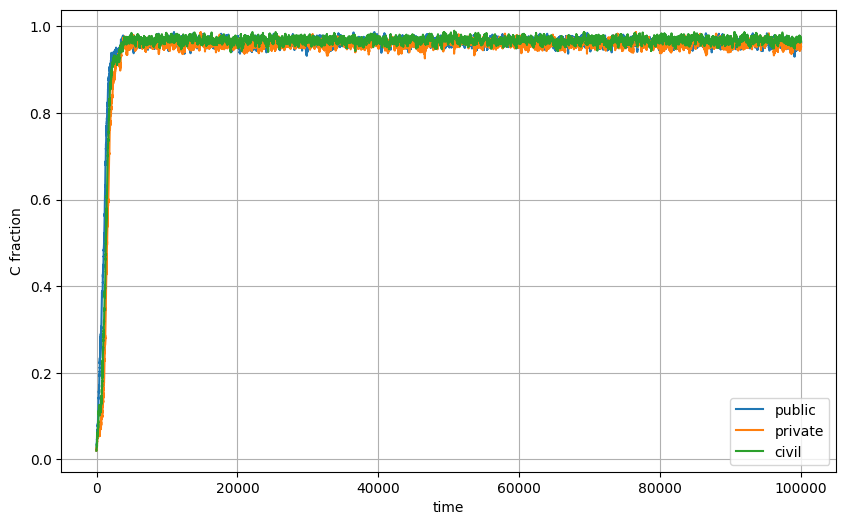

In [26]:
game.visualize_evol(mean_fractionss_hist, players=["public", "private", "civil"], xlabel="time", ylabel="C fraction")

##### Stationary Distribution

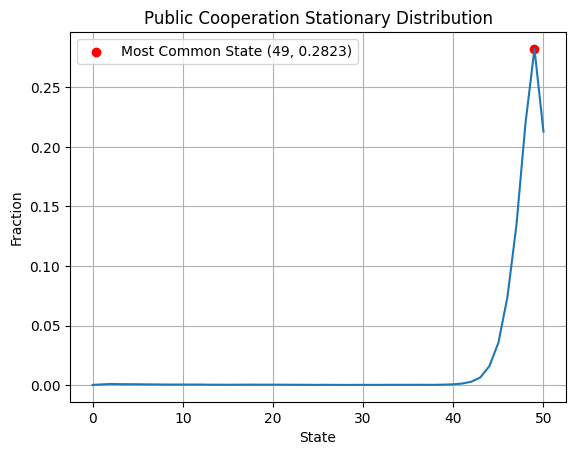

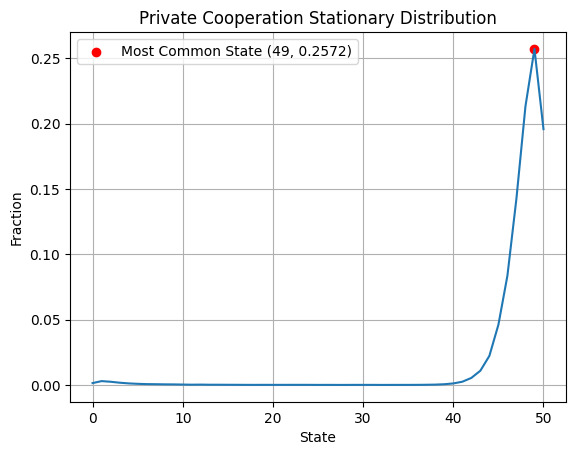

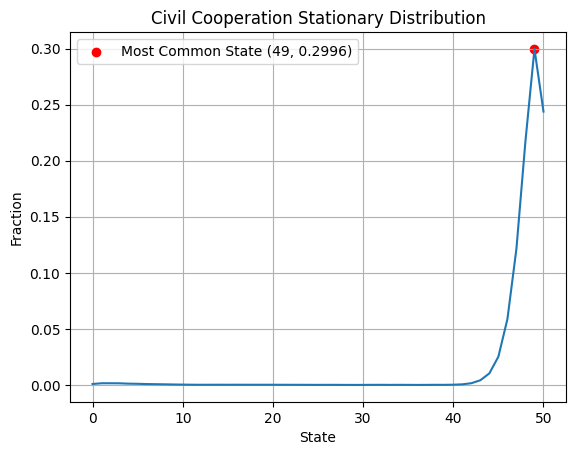

In [27]:
game.visualize_stationary_dist(Ps_hist=Ps_hist[0], title="Public Cooperation Stationary Distribution")
game.visualize_stationary_dist(Ps_hist=Ps_hist[1], title="Private Cooperation Stationary Distribution")
game.visualize_stationary_dist(Ps_hist=Ps_hist[2], title="Civil Cooperation Stationary Distribution")

### Computational Approximation (Markov Chain)

In [4]:
matrix = game.compute_trans_matrix(beta=0.08)
matrix.shape

(8, 8)

#### Visualization

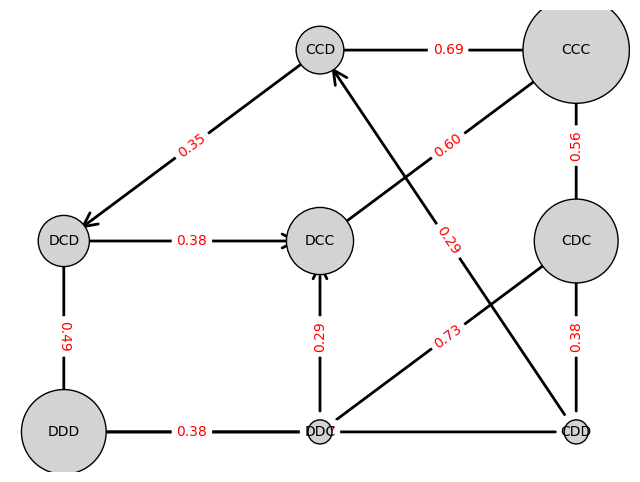

In [5]:
game.plot_transition_matrix(matrix, 1/len(P1), 40)

#### Compute stationary distrtibution (analytically) 

In [6]:
def compute_stationary_distribution(matrix):
    # Compute eigenvalues and right eigenvectors of the transpose of P.
    eigenvalues, eigenvectors = np.linalg.eig(matrix.T)
    
    # Find the index of the eigenvalue closest to 1.
    idx = np.argmin(np.abs(eigenvalues - 1))
    
    # Extract the corresponding eigenvector and take the real part (if it is complex)
    stationary = eigenvectors[:, idx].real
    
    # Normalize the eigenvector so that the sum of its components equals 1.
    stationary = stationary / np.sum(stationary)
    
    return stationary

stat = compute_stationary_distribution(matrix)
stat 

array([0.10581846, 0.04122291, 0.06222019, 0.04838605, 0.09110888,
       0.12915068, 0.08830201, 0.43379083])

##### Visualize stationary distributions

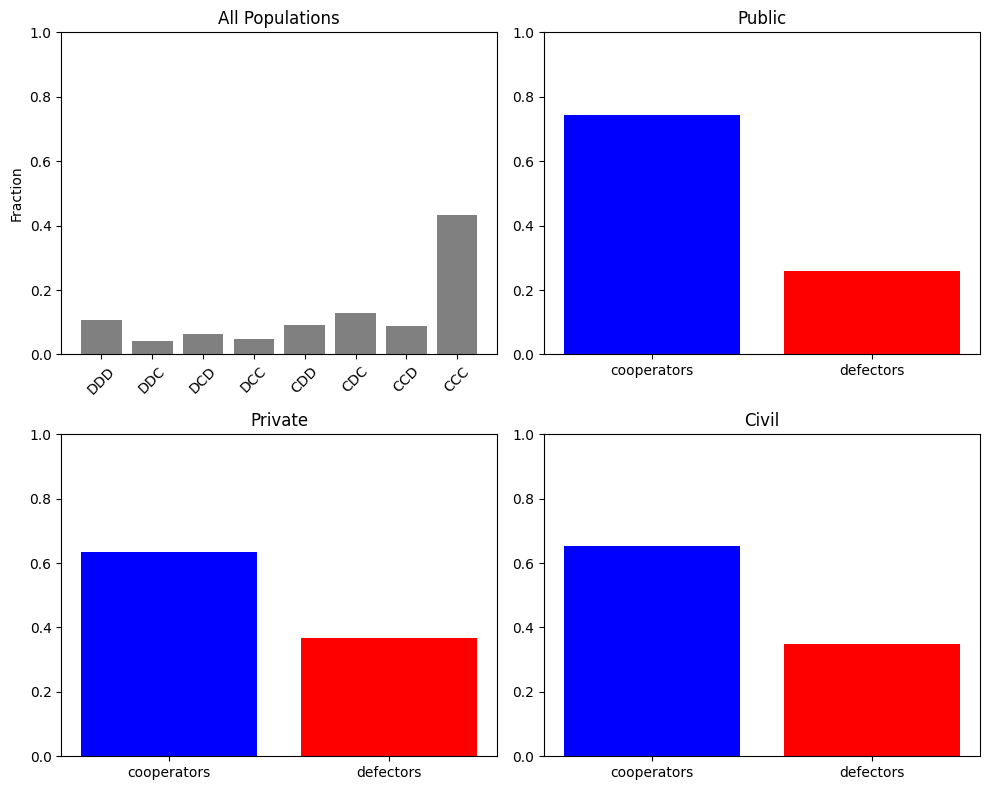

In [7]:
def plot_stationary_distribution_bar_charts(stationary, 
                                            states=None,
                                            sector_names=("public", "private", "civil")):
    """
    Plot bar charts for:
    1) The fraction of time spent in each monomorphic state.
    2) The fraction of cooperators vs. defectors in each sector (public, private, civil).
    
    Args:
        stationary (list or np.ndarray): A length-8 array of stationary probabilities 
            for the states in `states`.
        states (list): A list of 8 monomorphic states (e.g. ['DDD','DDC','DCD','DCC',
            'CDD','CDC','CCD','CCC']). Defaults to a standard ordering if None.
        sector_names (tuple): Names for each sector, e.g. ("public","private","civil").
    """
    if states is None:
        # Default ordering for binary strategies in 3 sectors
        states = ["DDD", "DDC", "DCD", "DCC", 
                  "CDD", "CDC", "CCD", "CCC"]
    
    # Check input lengths
    assert len(stationary) == 8, "Stationary distribution must have length 8."
    assert len(states) == 8, "States list must have length 8."
    
    # Create a 2x2 figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # 1) Bar chart of fraction in each monomorphic state
    ax_all = axes[0, 0]
    x_positions = np.arange(len(states))
    ax_all.bar(x_positions, stationary, color='gray')
    ax_all.set_xticks(x_positions)
    ax_all.set_xticklabels(states, rotation=45)
    ax_all.set_ylim([0, 1])
    ax_all.set_title("All Populations")
    ax_all.set_ylabel("Fraction")
    
    # Helper function to sum over states that have 'C' or 'D' in a given sector index
    def cooperator_defector_fraction(stationary, states, sector_index):
        """Returns (coops, defs) for the given sector_index."""
        coops = 0.0
        defs  = 0.0
        for i, st in enumerate(states):
            if st[sector_index] == 'C':
                coops += stationary[i]
            else:
                defs  += stationary[i]
        return coops, defs
    
    # 2) For each of the three sectors, do a bar chart of (cooperators, defectors)
    #    We assume sector 0 = public, 1 = private, 2 = civil, matching your naming
    #    but you can adapt as needed.
    
    # sector 0 -> public
    ax_pub = axes[0, 1]
    pub_coops, pub_defs = cooperator_defector_fraction(stationary, states, sector_index=0)
    ax_pub.bar([0, 1], [pub_coops, pub_defs], color=['blue', 'red'])
    ax_pub.set_xticks([0, 1])
    ax_pub.set_xticklabels(["cooperators", "defectors"])
    ax_pub.set_ylim([0, 1])
    ax_pub.set_title(sector_names[0].capitalize())
    
    # sector 1 -> private
    ax_priv = axes[1, 0]
    priv_coops, priv_defs = cooperator_defector_fraction(stationary, states, sector_index=1)
    ax_priv.bar([0, 1], [priv_coops, priv_defs], color=['blue', 'red'])
    ax_priv.set_xticks([0, 1])
    ax_priv.set_xticklabels(["cooperators", "defectors"])
    ax_priv.set_ylim([0, 1])
    ax_priv.set_title(sector_names[1].capitalize())
    
    # sector 2 -> civil
    ax_civ = axes[1, 1]
    civ_coops, civ_defs = cooperator_defector_fraction(stationary, states, sector_index=2)
    ax_civ.bar([0, 1], [civ_coops, civ_defs], color=['blue', 'red'])
    ax_civ.set_xticks([0, 1])
    ax_civ.set_xticklabels(["cooperators", "defectors"])
    ax_civ.set_ylim([0, 1])
    ax_civ.set_title(sector_names[2].capitalize())
    
    plt.tight_layout()
    plt.show()

plot_stationary_distribution_bar_charts(stat)

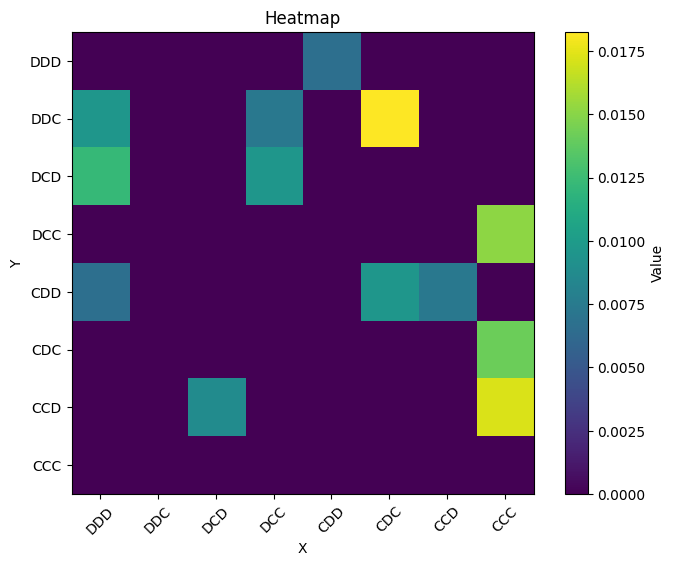

In [31]:
def plot_heatmap_matplotlib(matrix, title="Heatmap", xlabel="X", ylabel="Y", cmap="viridis"):
    """
    Plot a heatmap using Matplotlib's imshow.
    
    Args:
        matrix (np.ndarray): 2D numpy array to visualize.
        title (str): Title of the heatmap.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        cmap (str): Colormap to use.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.xticks(ticks=np.arange(len(states)), labels=states, rotation=45)
    plt.yticks(ticks=np.arange(len(states)), labels=states)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label="Value")
    plt.xticks(np.arange(matrix.shape[1]))
    plt.yticks(np.arange(matrix.shape[0]))
    plt.show()
import copy

def hamming_dist(a, b):
    dist = 0
    for i in range(len(a)):
        if a[i] != b[i]:
            dist += 1
    return dist

states = ["DDD", "DDC", "DCD", "DCC", "CDD", "CDC", "CCD", "CCC"]

mat = copy.deepcopy(matrix)
for i in range(len(mat)):
    for j in range(len(mat)):
        if i==j or hamming_dist(states[i], states[j]) > 1 or mat[i,j] < mat[j, i]:
            mat[i, j] = 0
plot_heatmap_matplotlib(mat)
